In [1]:
import os
import pandas as pd
import glob
from pathlib import Path

folders = glob.glob(os.path.join('./output_padim', '*/'))
csv_files = [file for folder in folders for file in glob.glob(os.path.join(folder, 'result.csv'))]
# print(csv_files)


all_data = []
for file in csv_files:
    df = pd.read_csv(file)
    all_data.append(df)

# concat all dataframes
# if each dataframes have different columns each other, use ignore_index=True 
# to create new index for each row
result_df = pd.concat(all_data, ignore_index=True)

# group by following kyes [data_class model layers   Rd  use_Rd  image_ROC  pixel_ROC] and calculate mean of image_ROC and pixel_ROC
# after calculating mean, rename image_ROC and pixel_ROC to mean_image_ROC and mean_pixel_ROC
result_df = result_df.groupby(['data_class', 'model', 'layers', 'Rd', 'use_Rd']).mean().reset_index()
result_df = result_df.rename(columns={'image_ROC': 'mean_image_ROC', 'pixel_ROC': 'mean_pixel_ROC'})
# remove seed column
result_df = result_df.drop(columns=['seed'])
# print(result_df[result_df['data_class'] == 'bottle'])

# save result dataframe to csv file
result_df.to_csv('./concatenate_result.csv',index=False)


In [2]:
import os
import pandas as pd
import glob
from pathlib import Path

folder = glob.glob(os.path.join('output_padim', '*/'))
csv_files = [file for folder in folders for file in glob.glob(os.path.join(folder, '*_result.csv'))]

all_data = []
for file in csv_files:
    df = pd.read_csv(file)
    all_data.append(df)
    
result_df = pd.concat(all_data, ignore_index=True)
# print(result_df)
keys = result_df.keys().tolist()
print(keys)
result_df = result_df.groupby(['data_class', 'model', 'layers', 'Rd', 'use_Rd']).mean().reset_index()
# csvとして保存
result_df.to_csv('./concatenate_result.csv',index=False)


['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC', 'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC', 'hole_image_ROC', 'hole_pixel_ROC', 'print_image_ROC', 'print_pixel_ROC', 'bent_wire_image_ROC', 'bent_wire_pixel_ROC', 'cable_swap_image_ROC', 'cable_swap_pixel_ROC', 'combined_image_ROC', 'combined_pixel_ROC', 'cut_inner_insulation_image_ROC', 'cut_inner_insulation_pixel_ROC', 'cut_outer_insulation_image_ROC', 'cut_outer_insulation_pixel_ROC', 'missing_cable_image_ROC', 'missing_cable_pixel_ROC', 'missing_wire_image_ROC', 'missing_wire_pixel_ROC', 'poke_insulation_image_ROC', 'poke_insulation_pixel_ROC', 'color_image_ROC', 'color_pixel_ROC', 'metal_contamination_image_ROC', 'metal_contamination_pixel_ROC', 'thread_image_ROC', 'thread_pixel_ROC', 'broken_large_image_ROC', 'broken_large_pixel_ROC', 'broken_small_image_ROC', 'broken_small_pixel_ROC', 'contamination_image_ROC', 'contamination_pixel_ROC', 'faulty_imprint_image_ROC', 'faulty_imprint_pixel_ROC', 

speacises:['zipper', 'tile', 'leather', 'wood', 'screw', 'hazelnut', 'transistor', 'metal', 'bottle', 'pill', 'toothbrush', 'carpet', 'cable', 'grid', 'capsule']
defect in zipper: ['zipper_broken_teeth', 'zipper_combined', 'zipper_fabric_border', 'zipper_fabric_interior', 'zipper_rough', 'zipper_split_teeth', 'zipper_squeezed_teeth']

speacis:zipper
['zipper_broken_teeth', 'zipper_combined', 'zipper_fabric_border', 'zipper_fabric_interior', 'zipper_rough', 'zipper_split_teeth', 'zipper_squeezed_teeth']
broken_teeth
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=10

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


fabric_border
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
fabric_interior
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
rough


/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


squeezed_teeth
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)


/tmp/ipykernel_1109314/2551111587.py:127: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


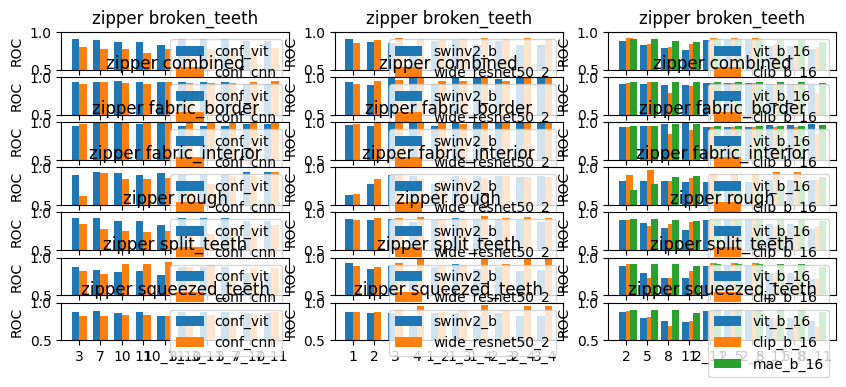

defect in tile: ['tile_crack', 'tile_glue_strip', 'tile_gray_stroke', 'tile_oil', 'tile_rough']

speacis:tile
['tile_crack', 'tile_glue_strip', 'tile_gray_stroke', 'tile_oil', 'tile_rough']
crack
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
glue_strip
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC',

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


oil
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
rough
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)


/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


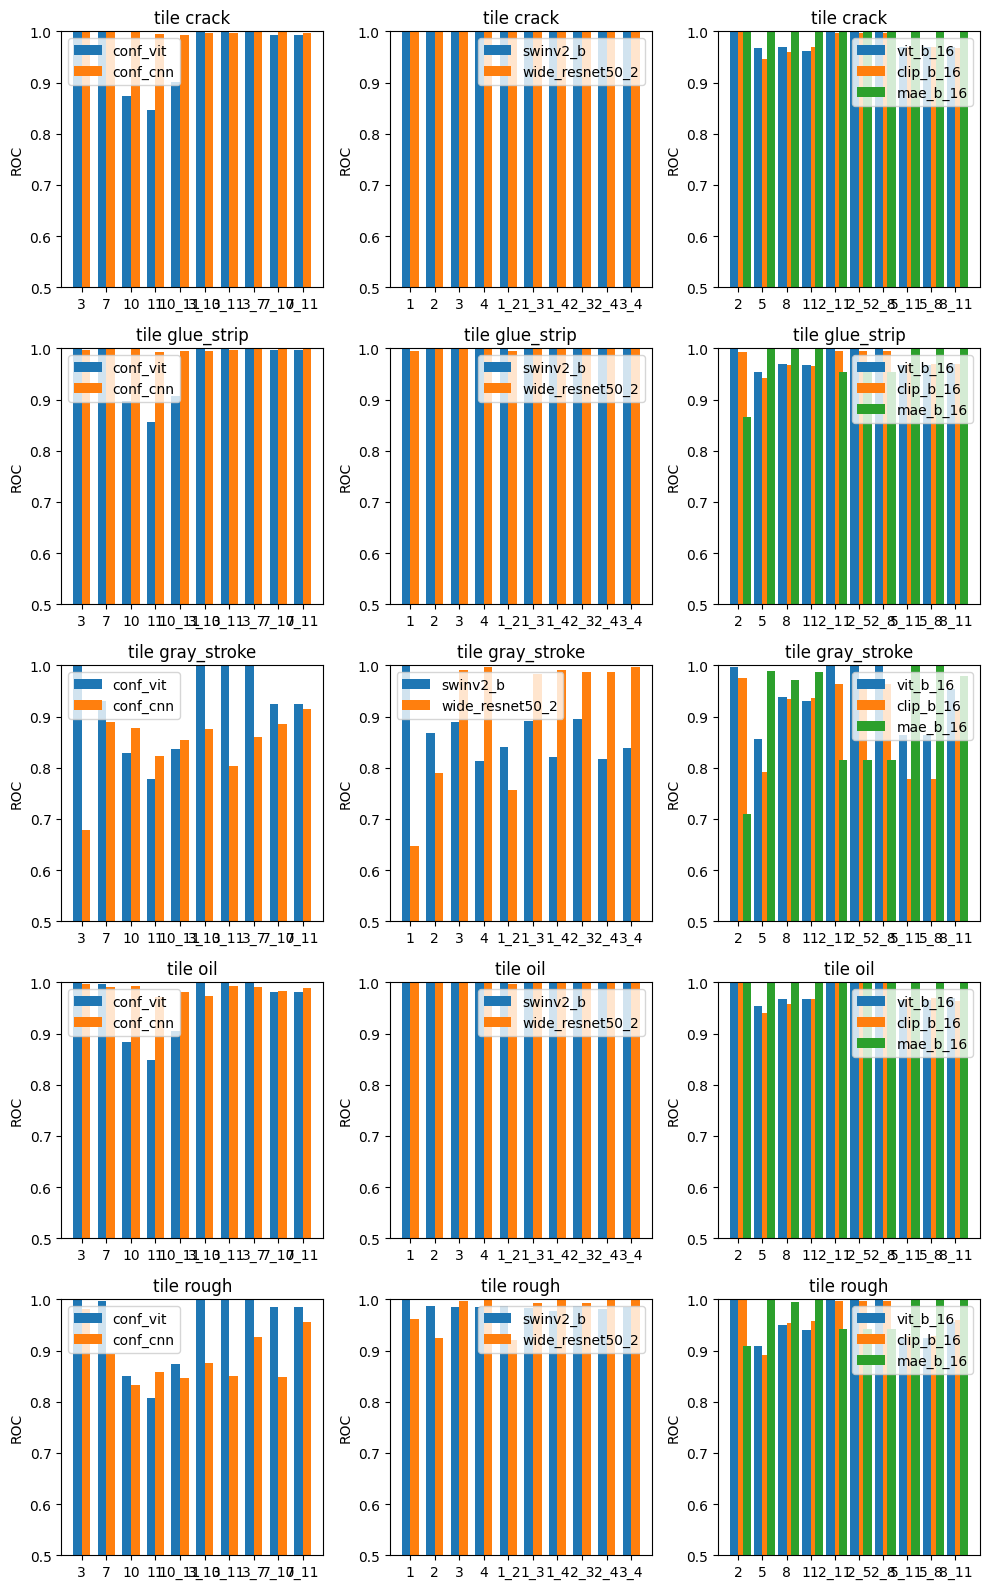

defect in leather: ['leather_color', 'leather_cut', 'leather_fold', 'leather_glue', 'leather_poke']

speacis:leather
['leather_color', 'leather_cut', 'leather_fold', 'leather_glue', 'leather_poke']
color
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
cut
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC'

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


fold
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
glue
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
poke
Index(['data_class', 

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


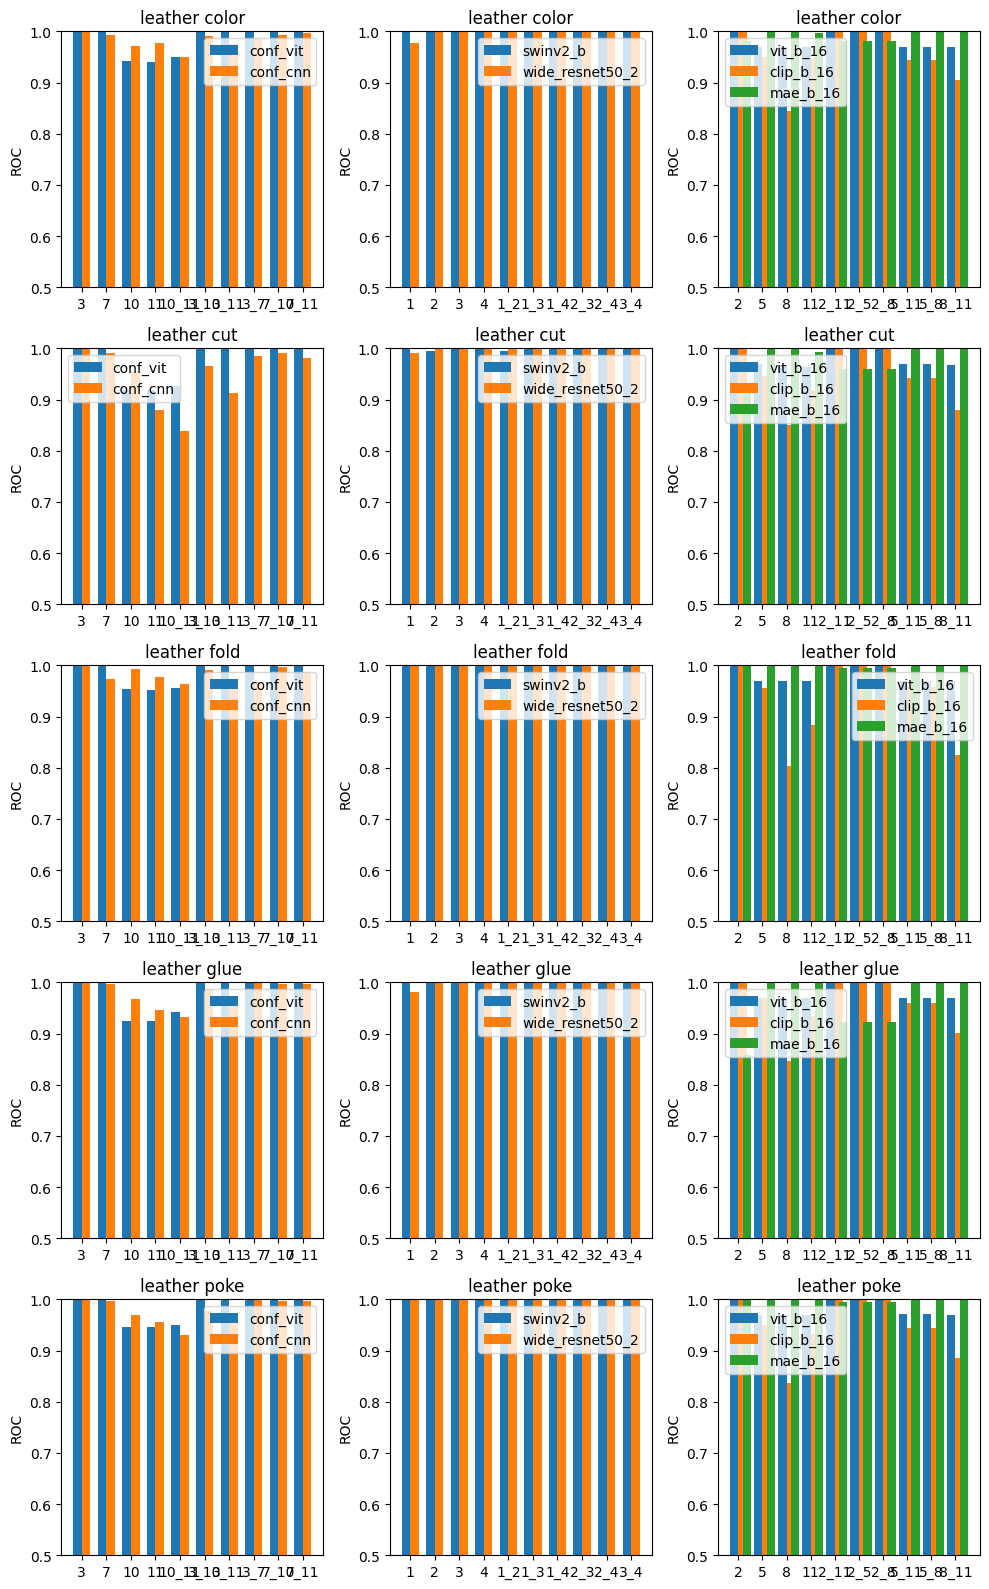

defect in wood: ['wood_color', 'wood_combined', 'wood_hole', 'wood_liquid', 'wood_scratch']

speacis:wood
['wood_color', 'wood_combined', 'wood_hole', 'wood_liquid', 'wood_scratch']
color
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
combined
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_te

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


hole
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
liquid
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
scratch
Index(['data_cla

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


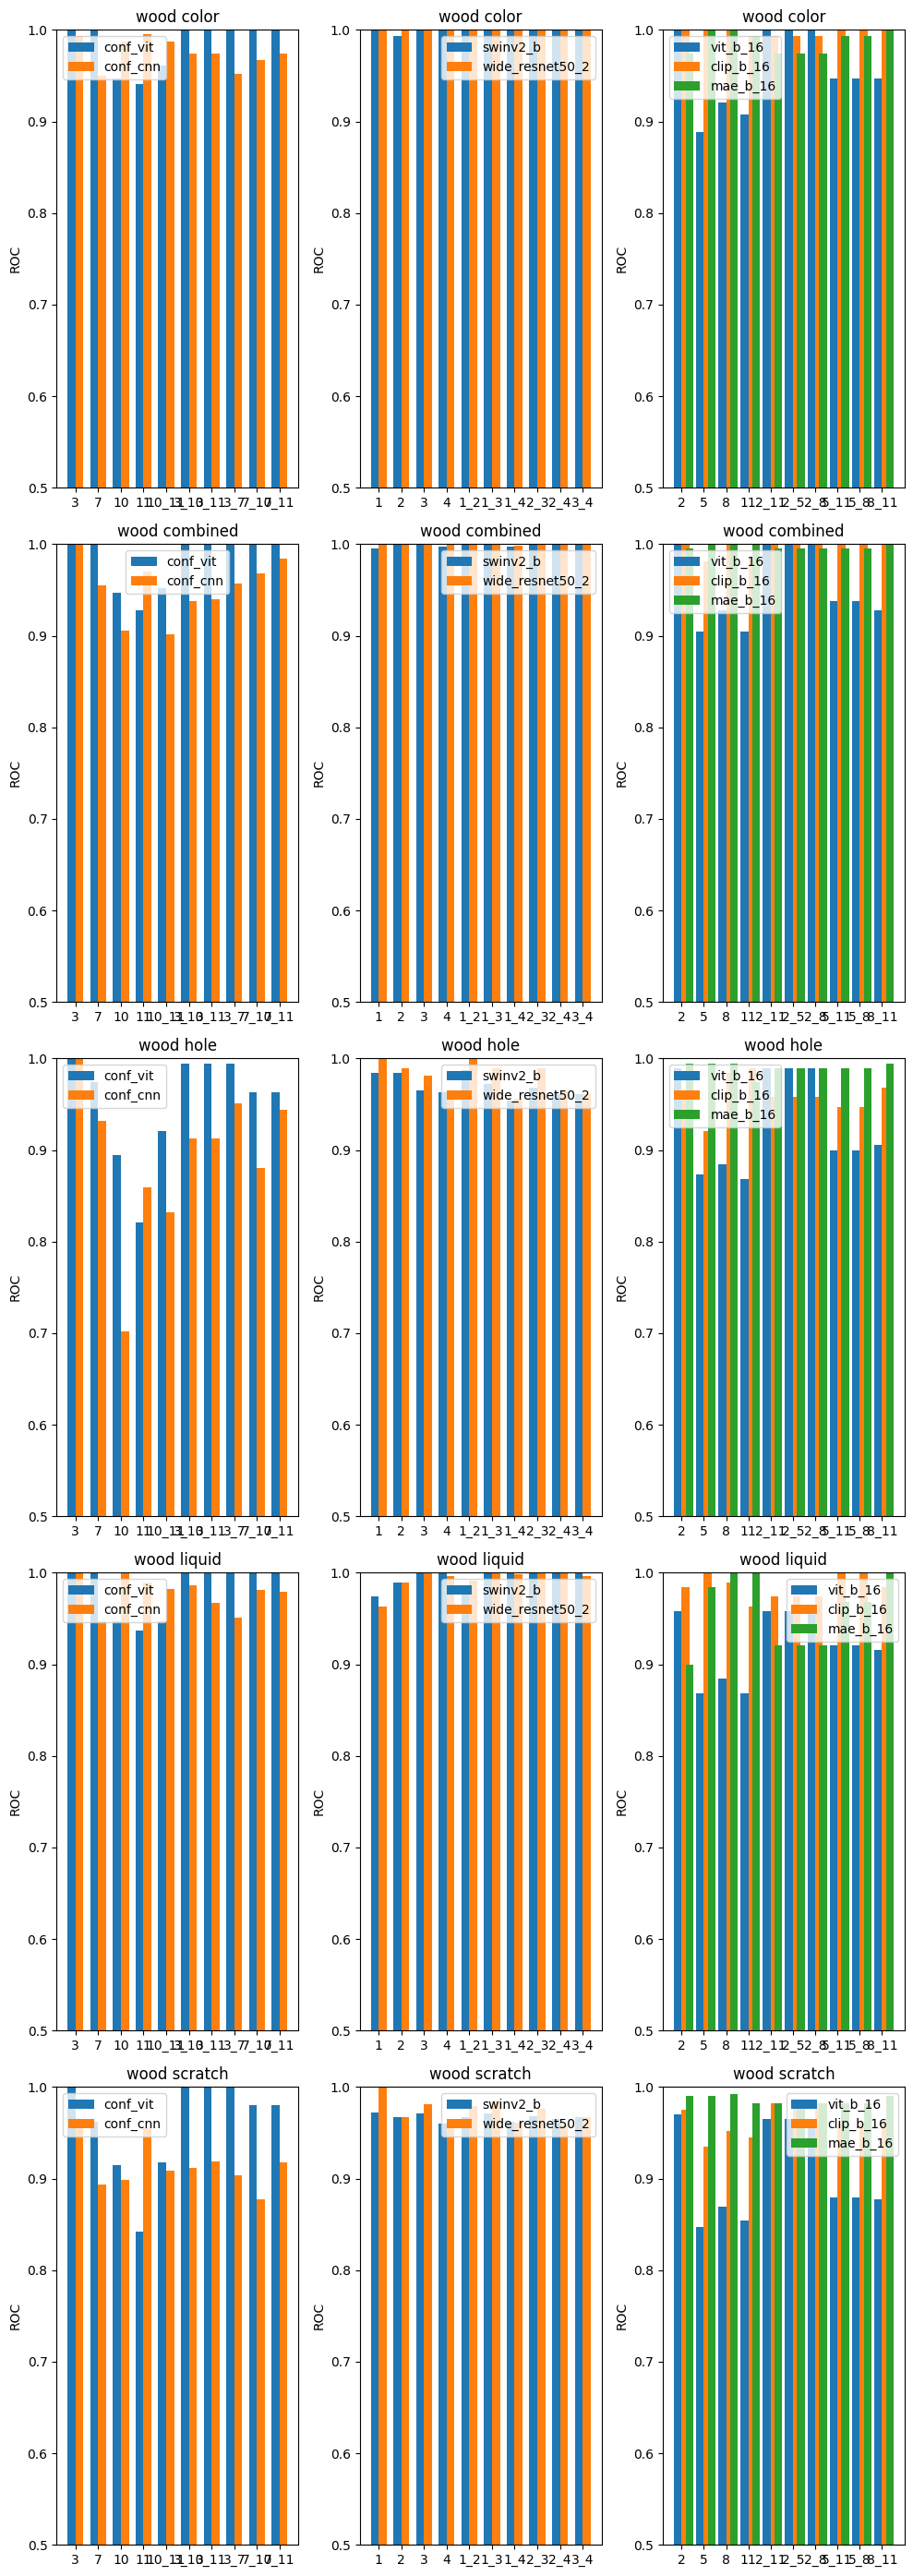

defect in screw: ['screw_manipulated_front', 'screw_scratch_head', 'screw_scratch_neck', 'screw_thread_side', 'screw_thread_top']

speacis:screw
['screw_manipulated_front', 'screw_scratch_head', 'screw_scratch_neck', 'screw_thread_side', 'screw_thread_top']
manipulated_front
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)


/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


scratch_head
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
scratch_neck
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
thread_sid

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


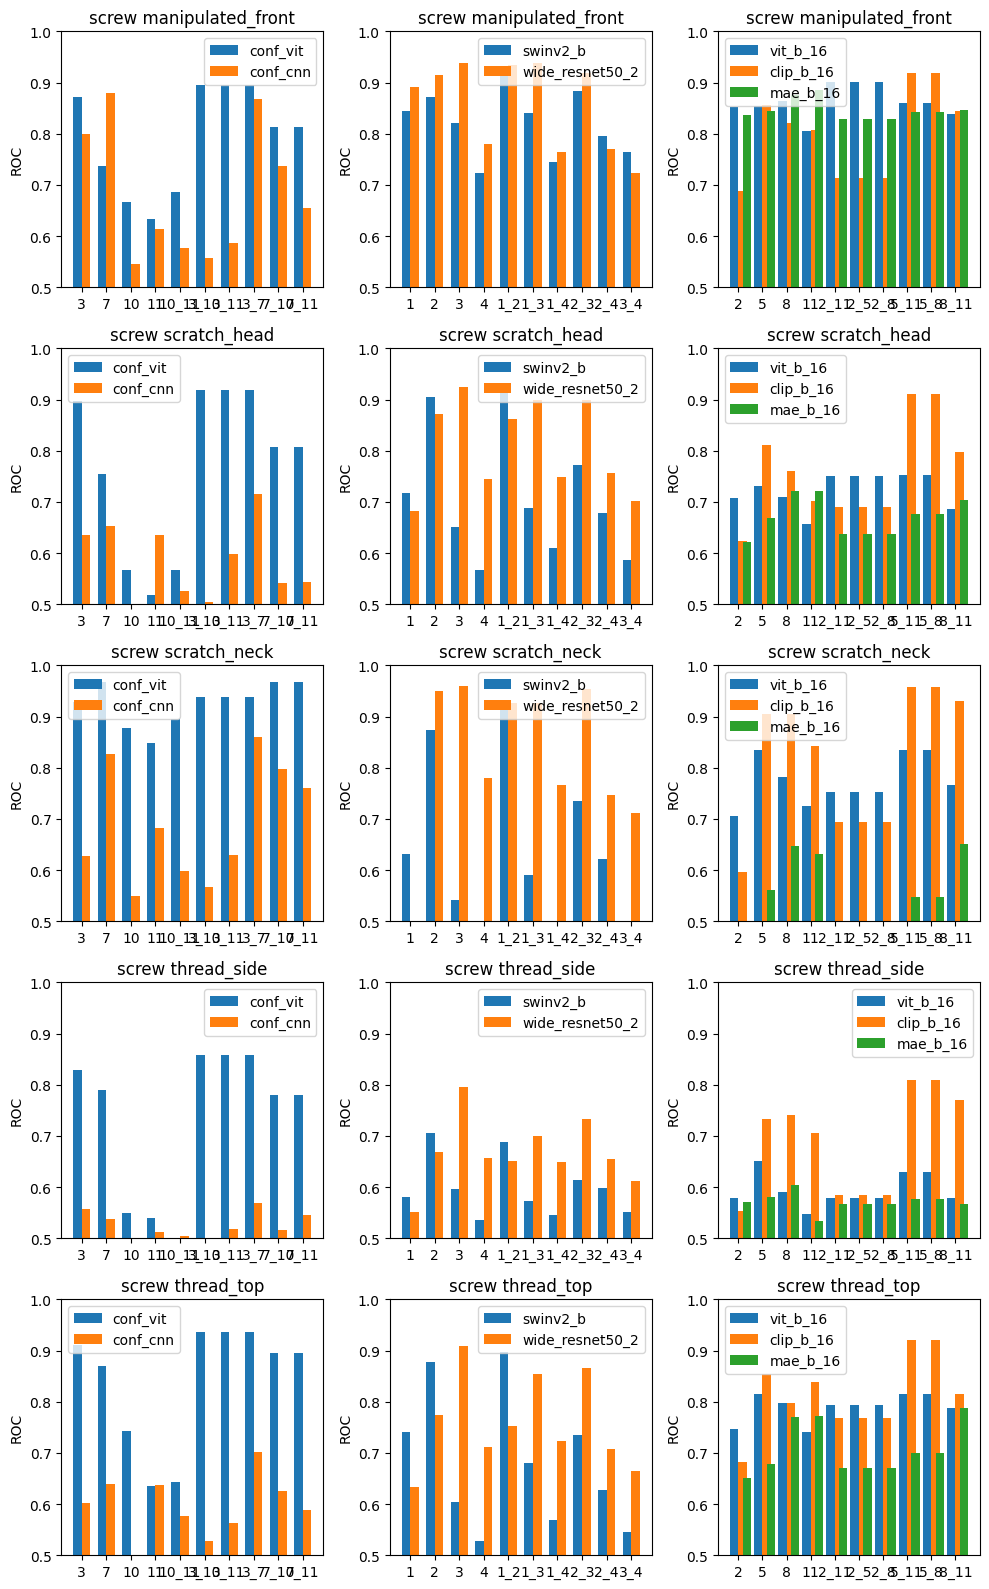

defect in hazelnut: ['hazelnut_crack', 'hazelnut_cut', 'hazelnut_hole', 'hazelnut_print']

speacis:hazelnut
['hazelnut_crack', 'hazelnut_cut', 'hazelnut_hole', 'hazelnut_print']
crack
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
cut
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


print
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)


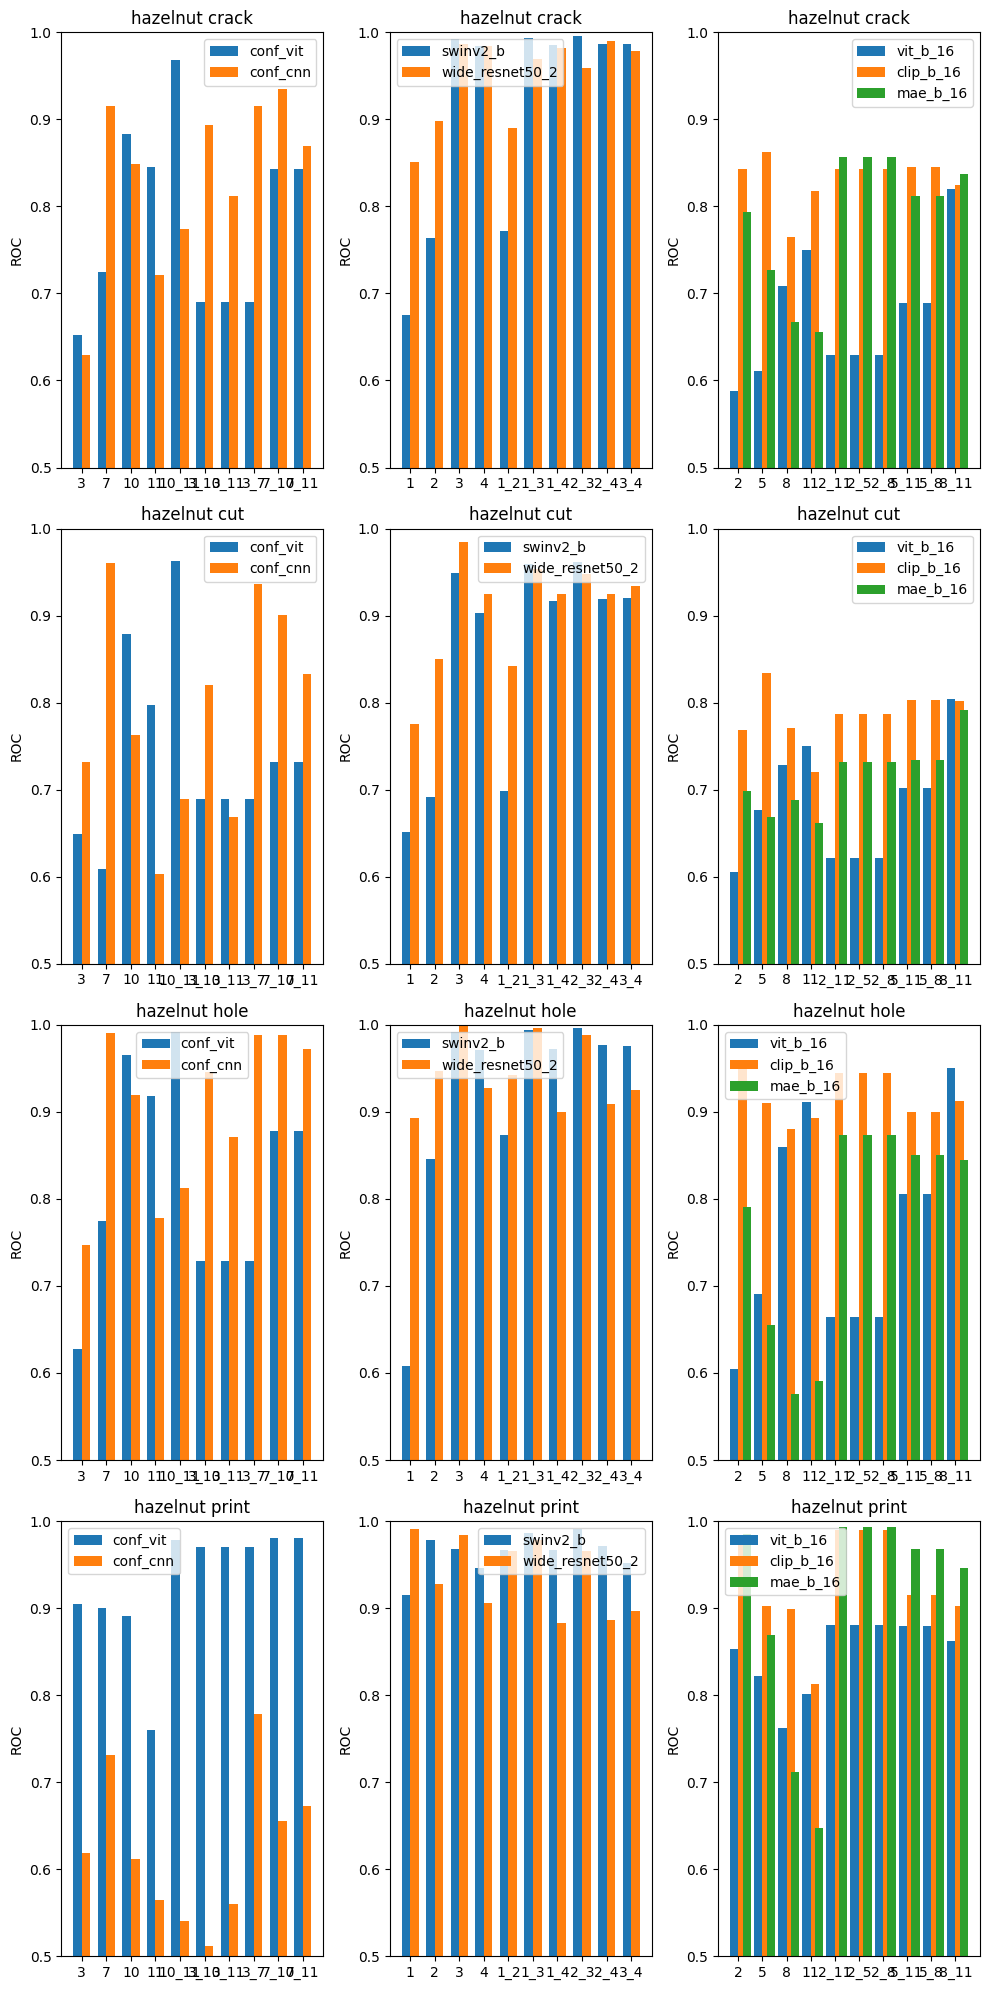

defect in transistor: ['transistor_bent_lead', 'transistor_cut_lead', 'transistor_damaged_case', 'transistor_misplaced']

speacis:transistor
['transistor_bent_lead', 'transistor_cut_lead', 'transistor_damaged_case', 'transistor_misplaced']
bent_lead
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
cut_lead
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


misplaced
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)


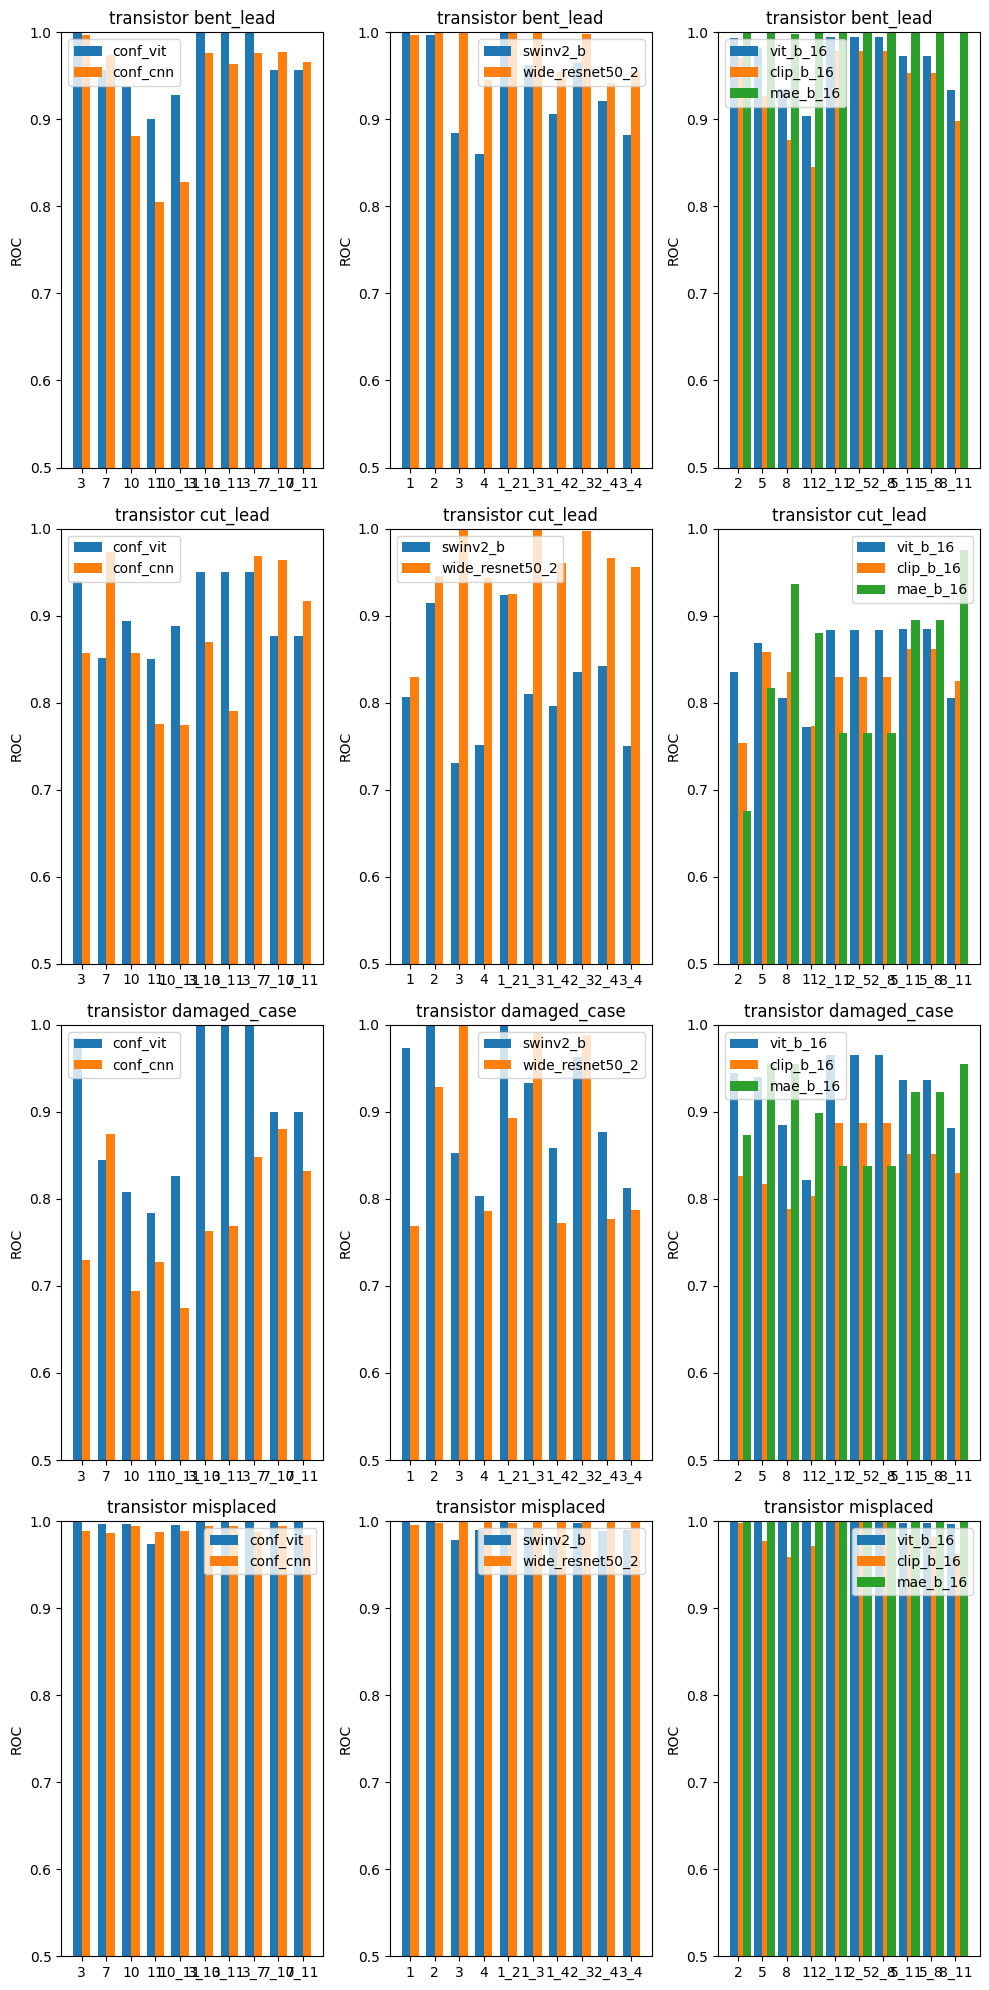

defect in metal: ['carpet_metal_contamination', 'grid_metal_contamination', 'metal_nut_bent', 'metal_nut_color', 'metal_nut_flip', 'metal_nut_scratch']

speacis:metal
['carpet_metal_contamination', 'grid_metal_contamination', 'metal_nut_bent', 'metal_nut_color', 'metal_nut_flip', 'metal_nut_scratch']
metal_contamination
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)


/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


metal_contamination
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
bent
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
color
Index

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


scratch
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)


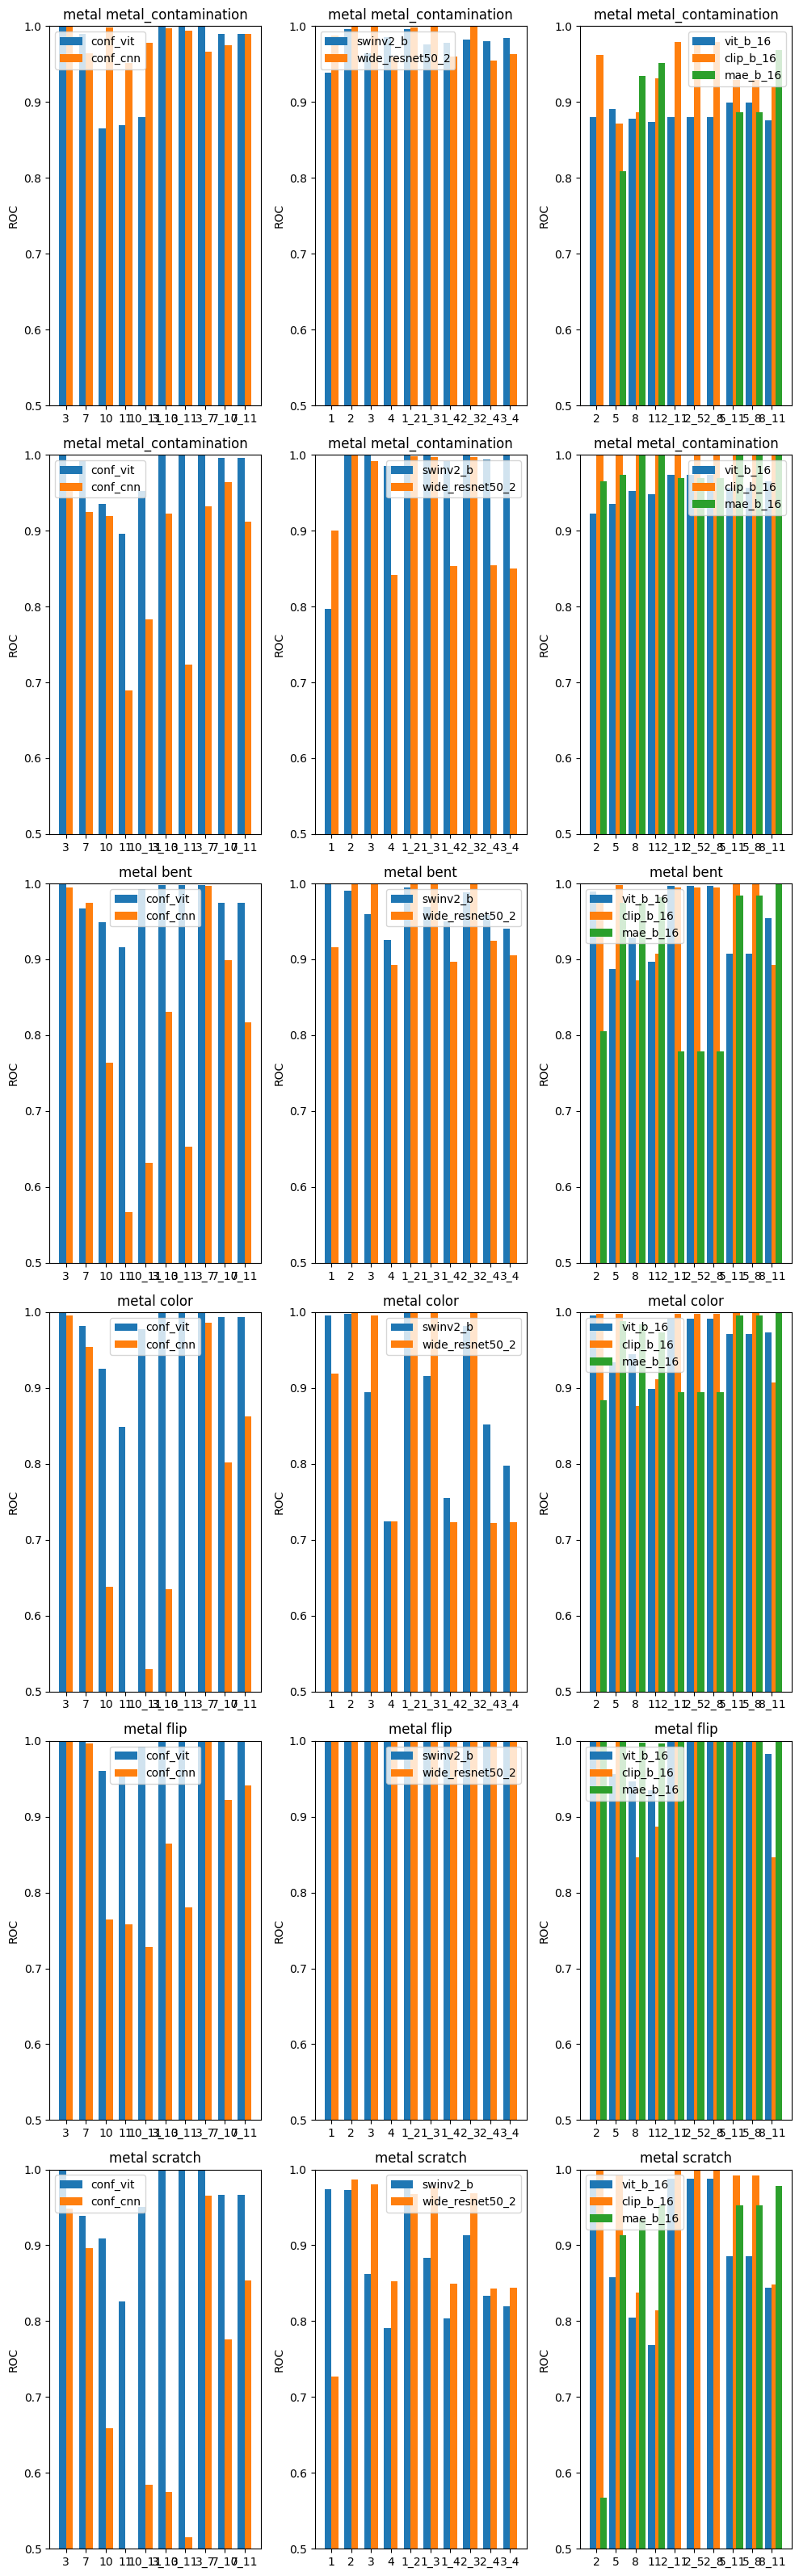

defect in bottle: ['bottle_broken_large', 'bottle_broken_small', 'bottle_contamination']

speacis:bottle
['bottle_broken_large', 'bottle_broken_small', 'bottle_contamination']
broken_large
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
broken_small
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'spl

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


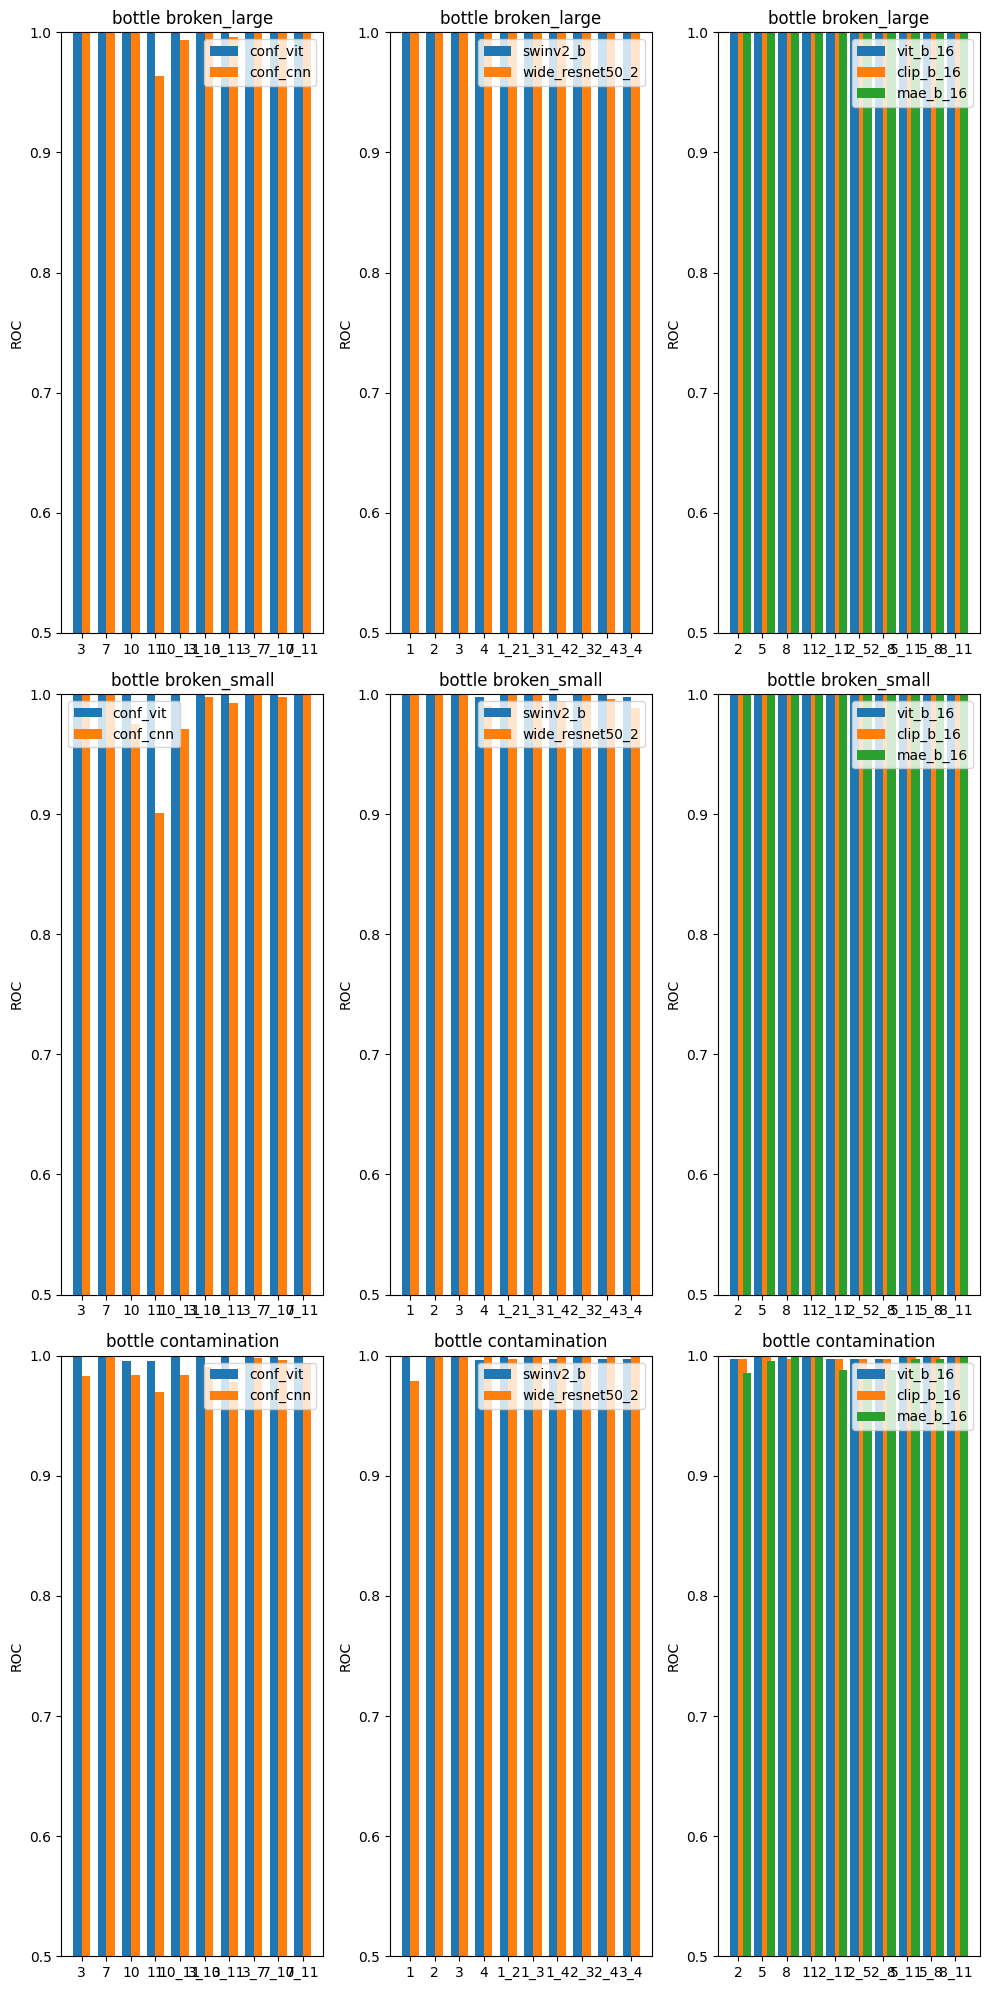

defect in pill: ['pill_color', 'pill_combined', 'pill_contamination', 'pill_crack', 'pill_faulty_imprint', 'pill_pill_type', 'pill_scratch']

speacis:pill
['pill_color', 'pill_combined', 'pill_contamination', 'pill_crack', 'pill_faulty_imprint', 'pill_pill_type', 'pill_scratch']
color
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
combined
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       '

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


faulty_imprint
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
pill_type
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
scratch
Ind

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


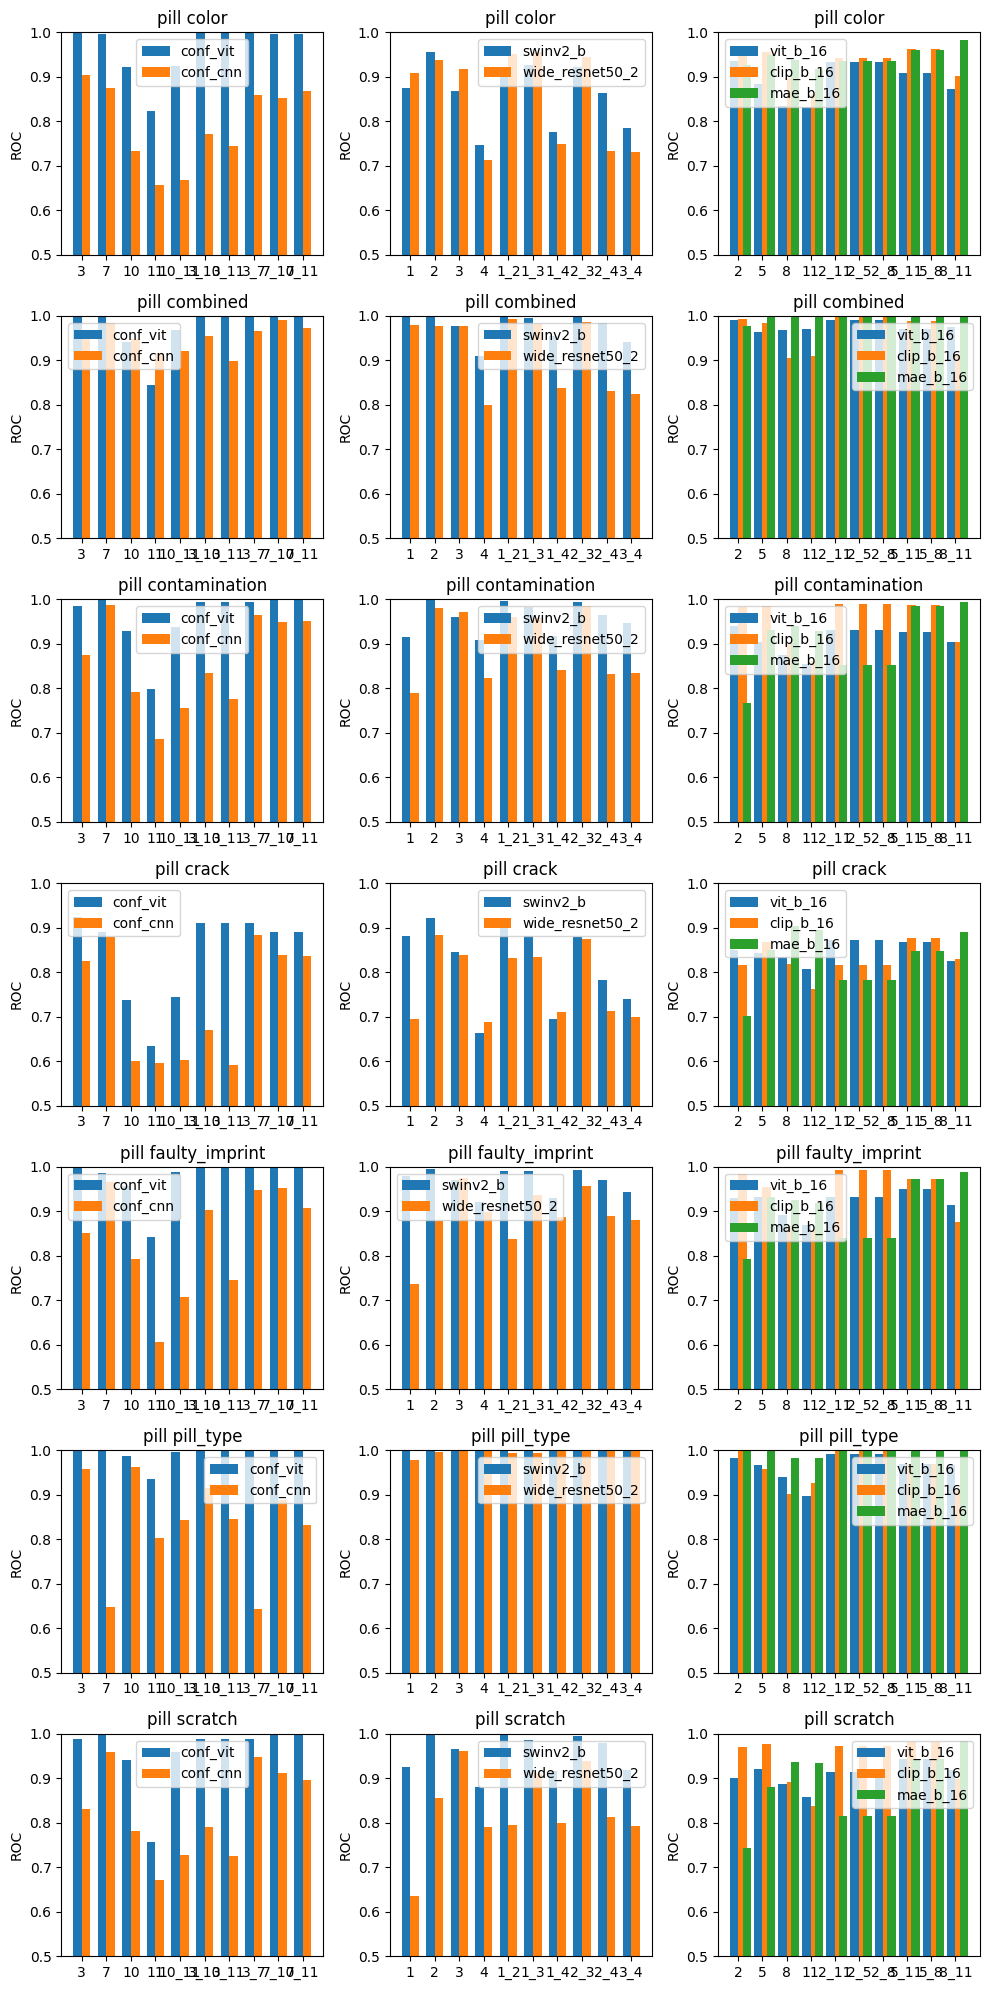

defect in toothbrush: ['toothbrush_defective']

speacis:toothbrush
['toothbrush_defective']
defective
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)


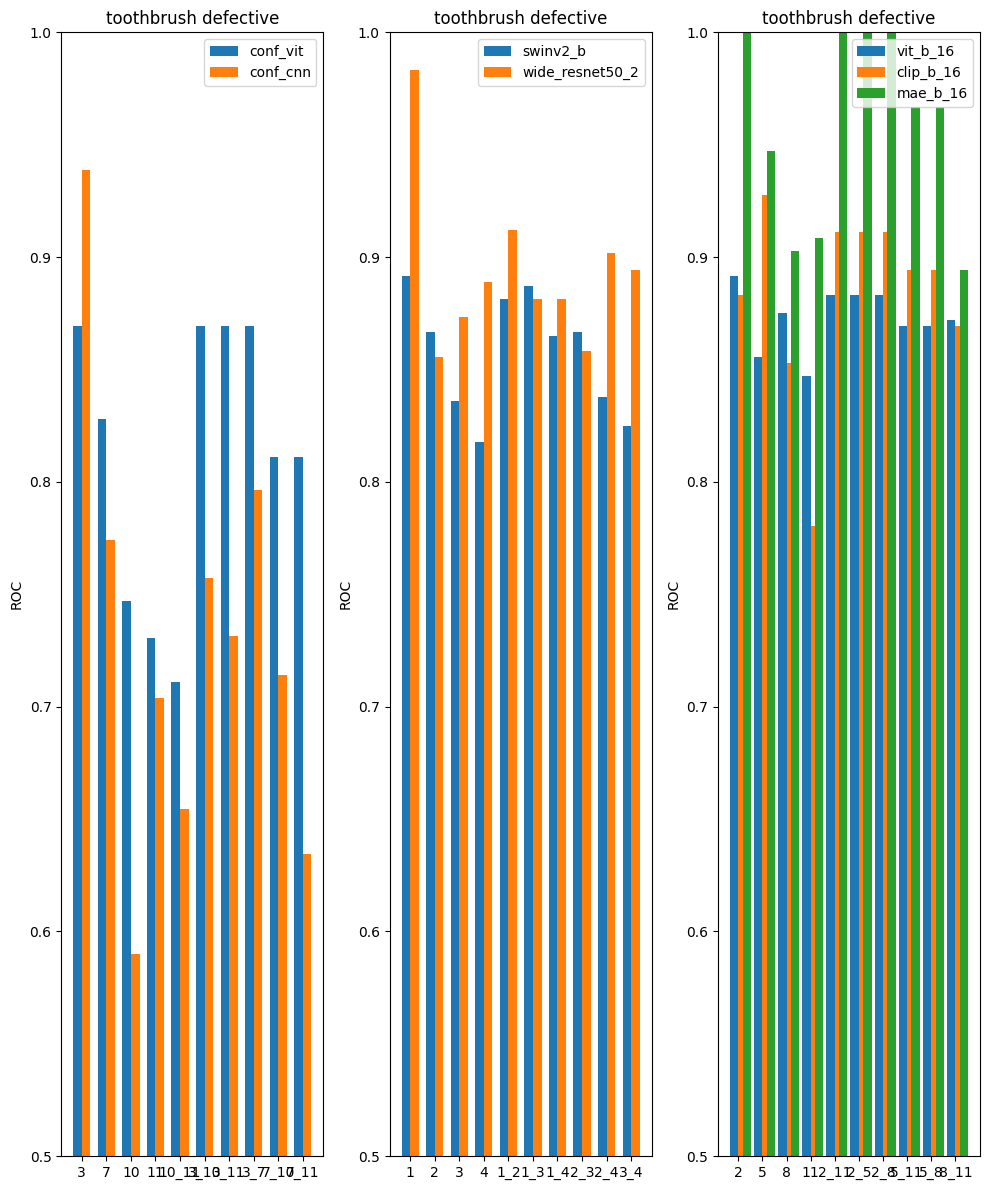

defect in carpet: ['carpet_color', 'carpet_cut', 'carpet_hole', 'carpet_metal_contamination', 'carpet_thread']

speacis:carpet
['carpet_color', 'carpet_cut', 'carpet_hole', 'carpet_metal_contamination', 'carpet_thread']
color
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
cut
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       '

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


metal_contamination
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
thread
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)


/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


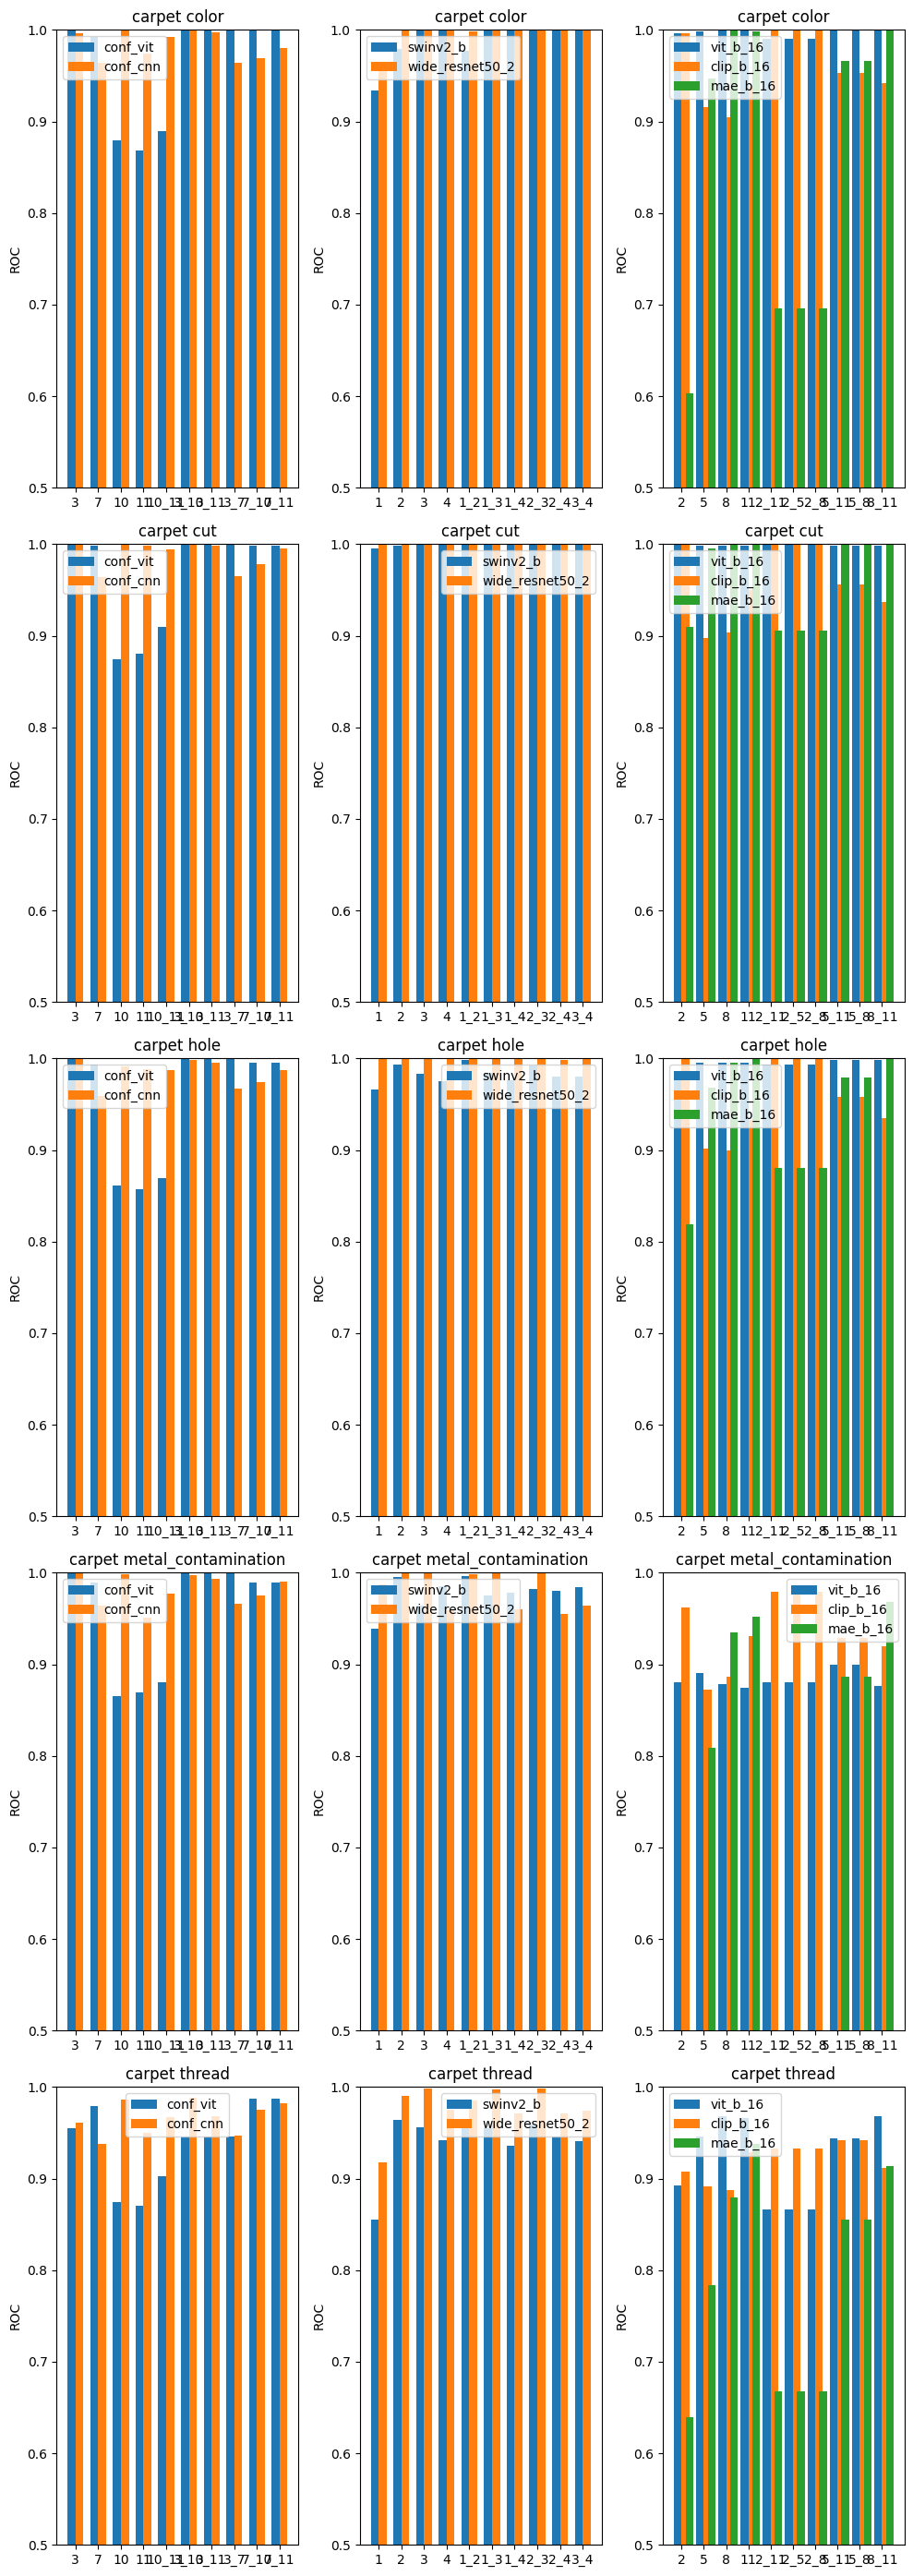

defect in cable: ['cable_bent_wire', 'cable_cable_swap', 'cable_combined', 'cable_cut_inner_insulation', 'cable_cut_outer_insulation', 'cable_missing_cable', 'cable_missing_wire', 'cable_poke_insulation']

speacis:cable
['cable_bent_wire', 'cable_cable_swap', 'cable_combined', 'cable_cut_inner_insulation', 'cable_cut_outer_insulation', 'cable_missing_cable', 'cable_missing_wire', 'cable_poke_insulation']
bent_wire
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
cable_swap
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


cut_outer_insulation
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
missing_cable
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
m

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


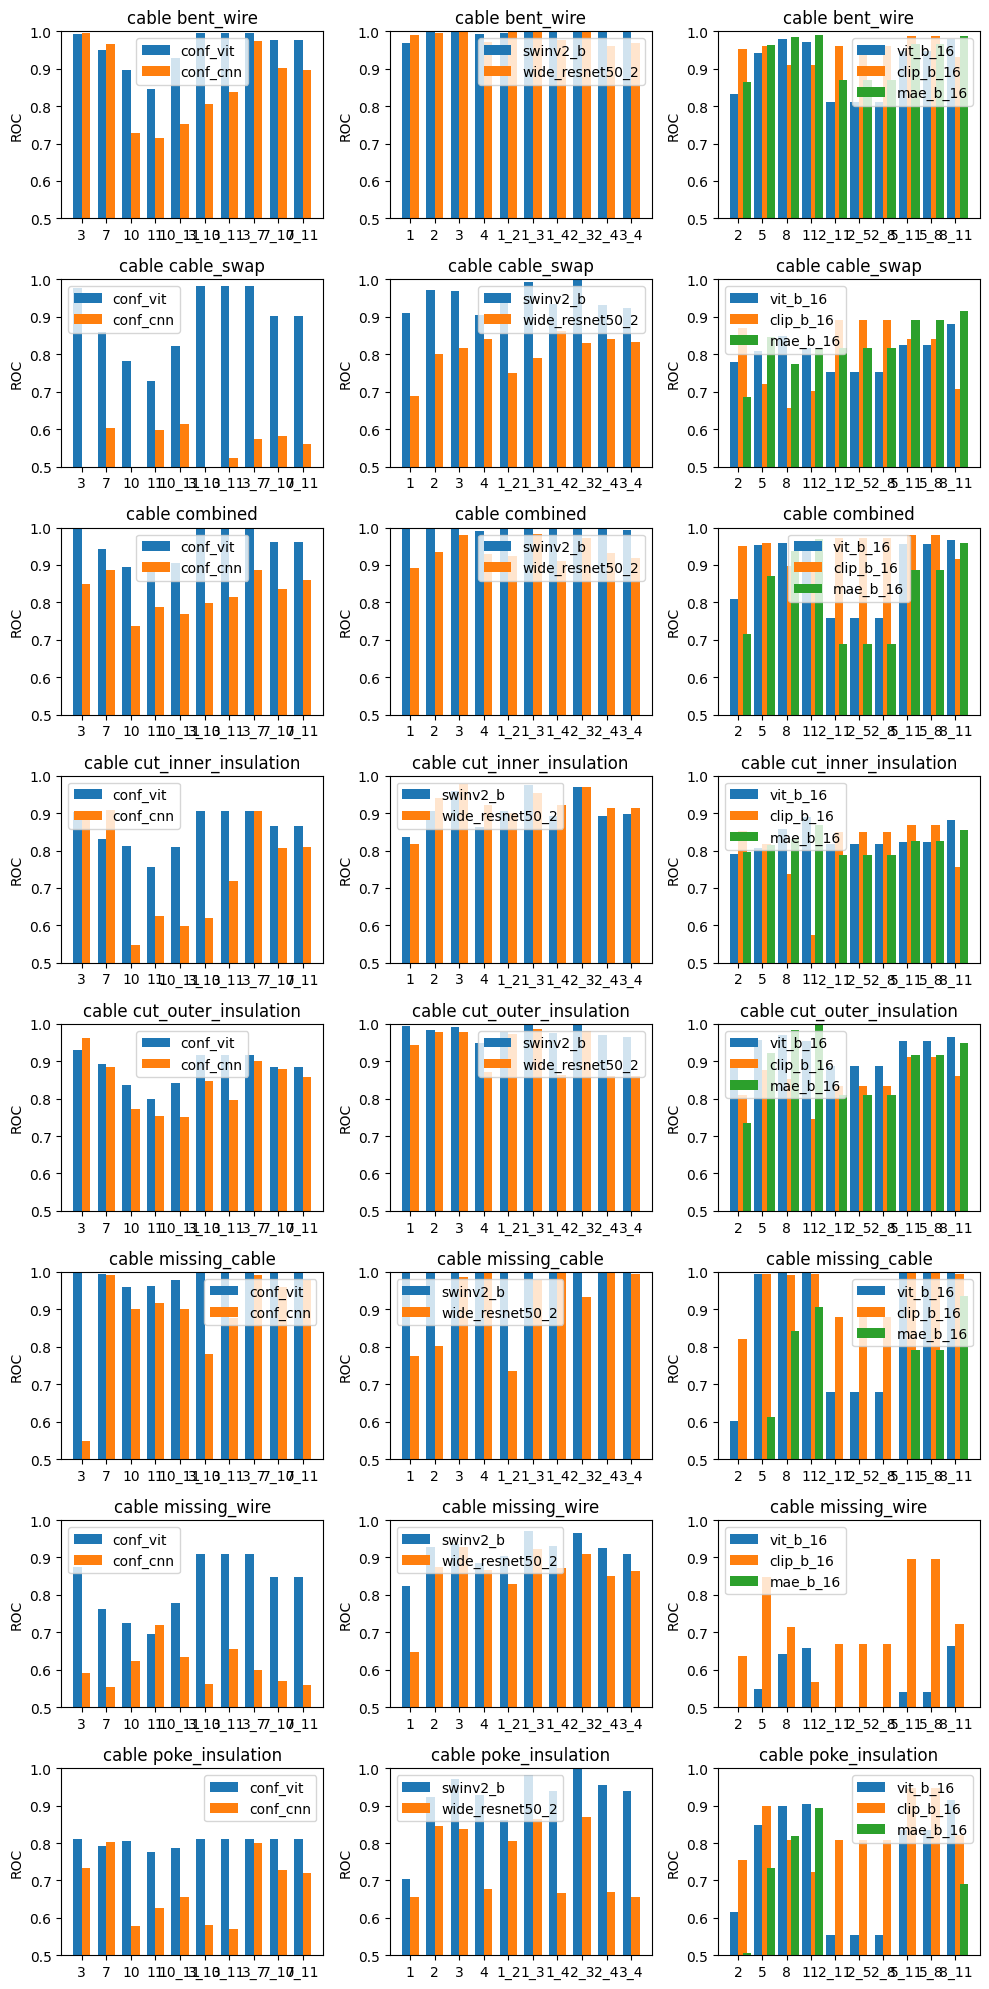

defect in grid: ['grid_bent', 'grid_broken', 'grid_glue', 'grid_metal_contamination', 'grid_thread']

speacis:grid
['grid_bent', 'grid_broken', 'grid_glue', 'grid_metal_contamination', 'grid_thread']
bent
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
broken
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


thread
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)


/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


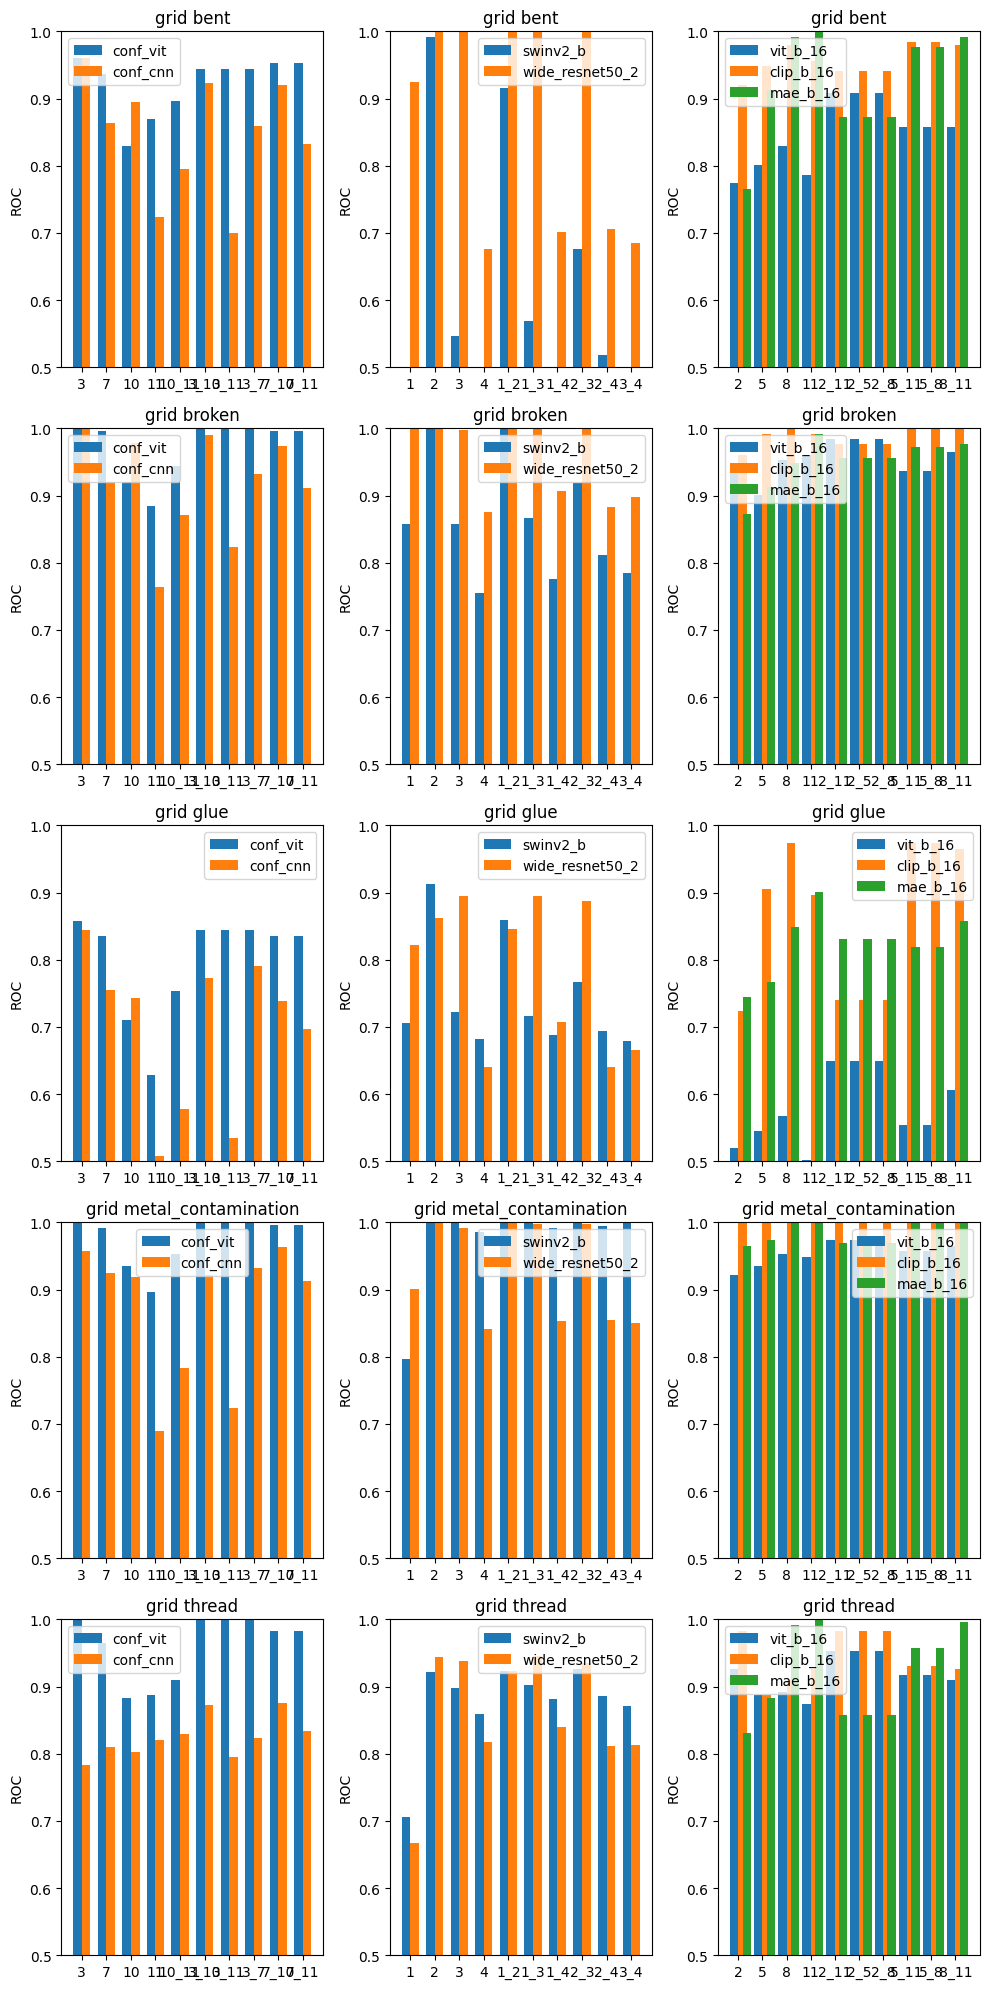

defect in capsule: ['capsule_crack', 'capsule_faulty_imprint', 'capsule_poke', 'capsule_scratch', 'capsule_squeeze']

speacis:capsule
['capsule_crack', 'capsule_faulty_imprint', 'capsule_poke', 'capsule_scratch', 'capsule_squeeze']
crack
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
faulty_imprint
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interi

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


poke
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
scratch
Index(['data_class', 'model', 'layers', 'Rd', 'use_Rd', 'crack_image_ROC',
       'crack_pixel_ROC', 'seed', 'cut_image_ROC', 'cut_pixel_ROC',
       ...
       'fabric_border_image_ROC', 'fabric_border_pixel_ROC',
       'fabric_interior_image_ROC', 'fabric_interior_pixel_ROC',
       'split_teeth_image_ROC', 'split_teeth_pixel_ROC',
       'squeezed_teeth_image_ROC', 'squeezed_teeth_pixel_ROC',
       'liquid_image_ROC', 'liquid_pixel_ROC'],
      dtype='object', length=102)
squeeze
Index(['data_cl

/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]
/tmp/ipykernel_1109314/2551111587.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _selected_data = _selected_data[selected_data['data_class'] == name]


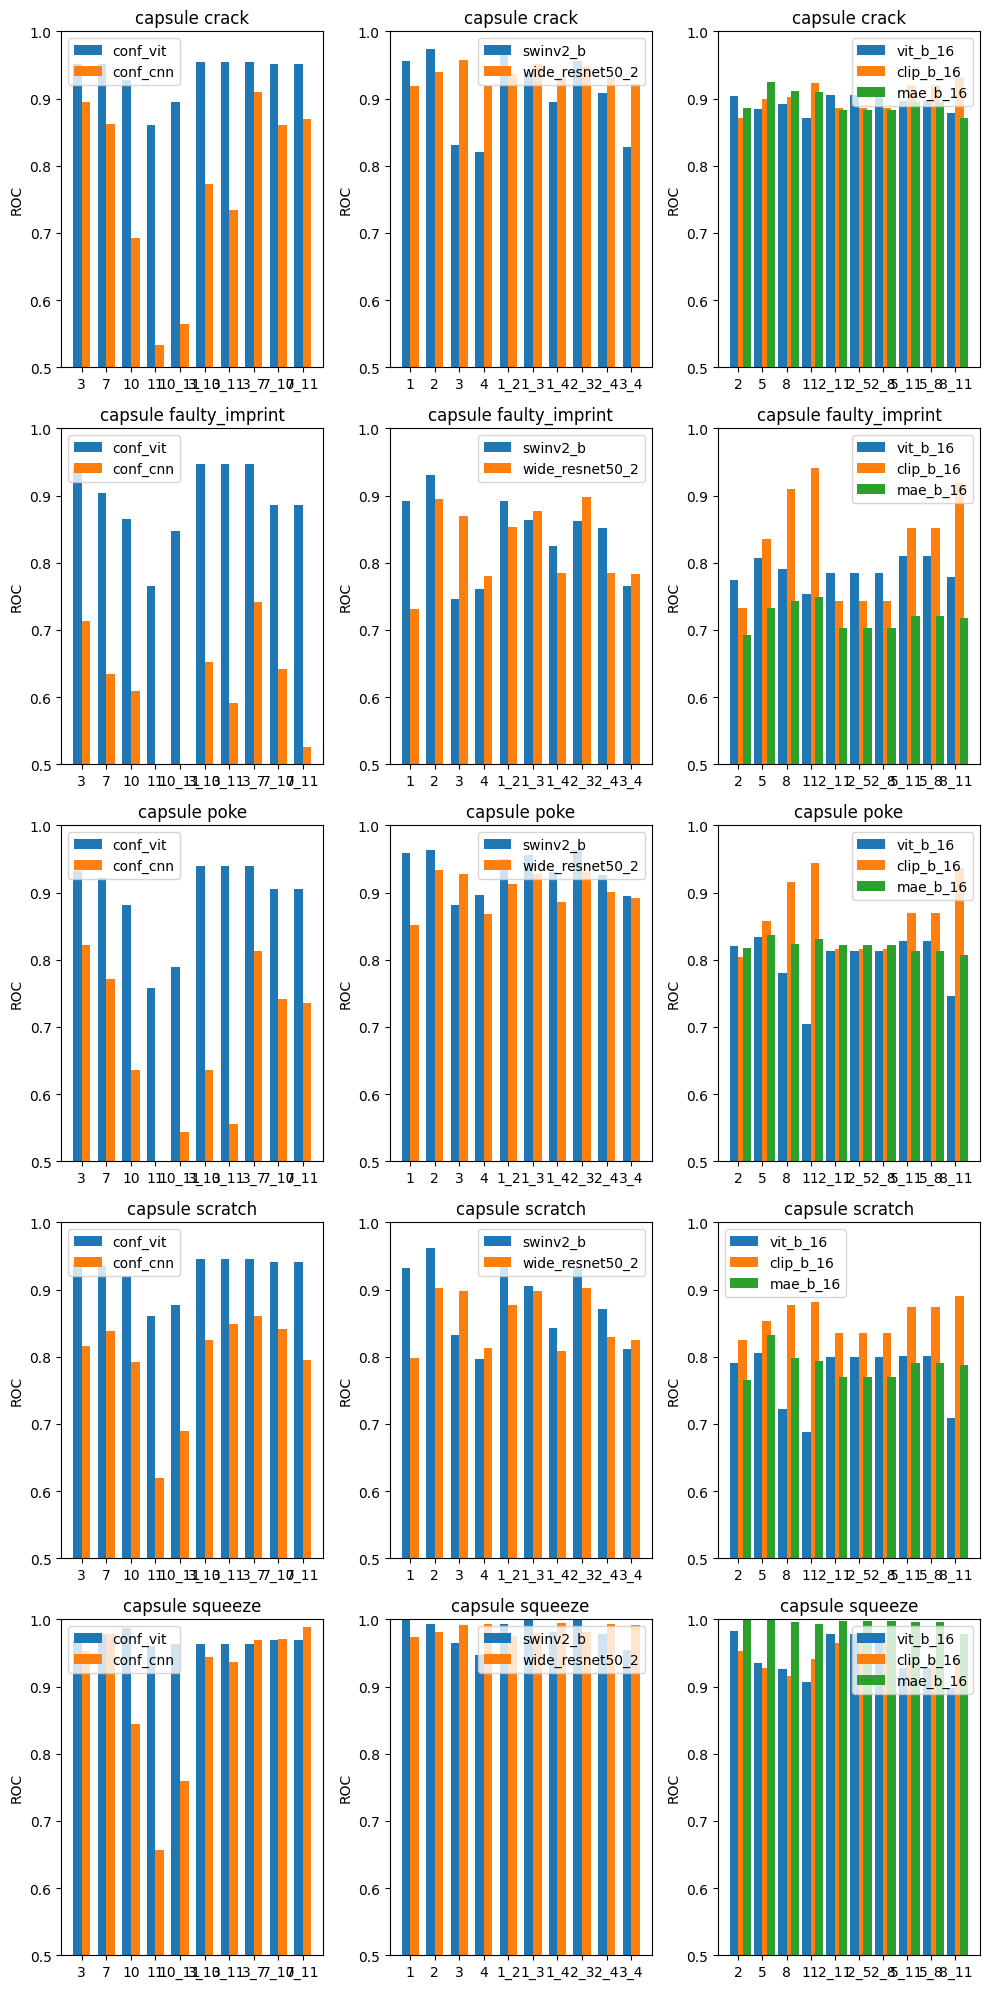

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math

# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax[idx%2][idx%2].annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

speacises = result_df['data_class'].unique().tolist()
# 各配列の文字列について_で分割，その配列のうち0番目の要素を取得して，uniqueな配列に戻す
speacises = list(set([name.split('_')[0] for name in speacises]))
print(f'speacises:{speacises}')
size = [10]*len(speacises)
h = [1,4,4,7,4,5,5,8,5,5,3,7,5,5,5]

for _,speacis in zip(h,speacises):
    selected_data = result_df[result_df['data_class'].str.contains(speacis)]
    defect_name = selected_data['data_class'].unique().tolist()
    print(f'defect in {speacis}: {defect_name}\n')

    # サブプロットを作成
    fig, ax = plt.subplots(len(defect_name), 3, figsize=(10, _*4))
    
    width = 0.35   
    print(f'speacis:{speacis}')
    print(selected_data['data_class'].unique().tolist())


    for idx,name in enumerate(defect_name):  
        # selected_dataの'data_class'がnameと一致するものを抽出
        _selected_data = selected_data[selected_data['data_class'].isin([name])]

        if name.find('metal_nut') != -1:
            extract_name = name.split('_')[2]
        else:
            extract_name = name.split('_', 1)[1]
        print(extract_name)
        print(selected_data.keys())
        # 選択したキーのみを抽出
        _selected_data = _selected_data[['data_class', 'model', 'layers', 'Rd', 'use_Rd', f'{extract_name}_image_ROC', f'{extract_name}_pixel_ROC']]

        # data_classがextract_nameのものを抽出
        _selected_data = _selected_data[selected_data['data_class'] == name]
        # print(selected_data)

        # selected_dataのうちmodelがswinv2_bもしくはwide_resnet50_2のものを抽出
        sr_data = _selected_data[_selected_data['model'].isin(['swinv2_b', 'wide_resnet50_2'])]
        sr_layers = sr_data['layers'].unique().tolist()
        # selected_dataのうちmodelがconformer_b_16_vitもしくはconformer_b_16_cnnであるものを抽出
        conformer_data = _selected_data[_selected_data['model'].isin(['conformer_b_16_vit', 'conformer_b_16_cnn'])]
        conformer_layers = conformer_data['layers'].unique().tolist()
        # selected_dataのうちmodelがvit_b_16であるものを抽出
        vit_b_data = _selected_data[_selected_data['model'].isin(['vit_b_16','clip_b_16','mae_b_16',])]
        vit_b_layers = vit_b_data['layers'].unique().tolist()

        # 棒グラフの描画
        conf_vit = conformer_data[conformer_data['model']=='conformer_b_16_vit'][f'{extract_name}_image_ROC']
        conf_cnn = conformer_data[conformer_data['model']=='conformer_b_16_cnn'][f'{extract_name}_image_ROC']
        swinv2 = sr_data[sr_data['model']=='swinv2_b'][f'{extract_name}_image_ROC']
        resnet = sr_data[sr_data['model']=='wide_resnet50_2'][f'{extract_name}_image_ROC']
        vit_b = vit_b_data[vit_b_data['model']=='vit_b_16'][f'{extract_name}_image_ROC']
        clip_b = vit_b_data[vit_b_data['model']=='clip_b_16'][f'{extract_name}_image_ROC']
        mae_b = vit_b_data[vit_b_data['model']=='mae_b_16'][f'{extract_name}_image_ROC']

        if len(defect_name)==1:
            rects1 = ax[0].bar(np.arange(len(conformer_layers)) - width/2, conf_vit, width, label='conf_vit')
            rects2 = ax[0].bar(np.arange(len(conformer_layers)) + width/2, conf_cnn, width, label='conf_cnn')
            ax[0].set_ylabel('ROC')
            ax[0].set_title(f'{speacis} {extract_name}')
            ax[0].set_xticks(np.arange(len(conformer_layers)))
            ax[0].set_xticklabels(conformer_layers)
            ax[0].legend()
            ax[0].set_ylim(0.5,1)

            rects1 = ax[1].bar(np.arange(len(sr_layers)) - width/2, swinv2, width, label='swinv2_b')
            rects2 = ax[1].bar(np.arange(len(sr_layers)) + width/2, resnet, width, label='wide_resnet50_2')
            ax[1].set_ylabel('ROC')
            ax[1].set_title(f'{speacis} {extract_name}')
            ax[1].set_xticks(np.arange(len(sr_layers)))
            ax[1].set_xticklabels(sr_layers)
            ax[1].legend()
            ax[1].set_ylim(0.5,1)
        
            rects1 = ax[2].bar(np.arange(len(vit_b_layers)) - width/2, vit_b, width, label='vit_b_16')
            rects2 = ax[2].bar(np.arange(len(vit_b_layers)) + width/2, clip_b, width, label='clip_b_16')
            rects3 = ax[2].bar(np.arange(len(vit_b_layers)) + width, mae_b, width, label='mae_b_16')
            ax[2].set_ylabel('ROC')
            ax[2].set_title(f'{speacis} {extract_name}')
            ax[2].set_xticks(np.arange(len(vit_b_layers)))
            ax[2].set_xticklabels(vit_b_layers)
            ax[2].legend()
            ax[2].set_ylim(0.5,1)
        else:
            rects1 = ax[idx][0].bar(np.arange(len(conformer_layers)) - width/2, conf_vit, width, label='conf_vit')
            rects2 = ax[idx][0].bar(np.arange(len(conformer_layers)) + width/2, conf_cnn, width, label='conf_cnn')
            ax[idx][0].set_ylabel('ROC')
            ax[idx][0].set_title(f'{speacis} {extract_name}')
            ax[idx][0].set_xticks(np.arange(len(conformer_layers)))
            ax[idx][0].set_xticklabels(conformer_layers)
            ax[idx][0].legend()
            ax[idx][0].set_ylim(0.5,1)

            rects1 = ax[idx][1].bar(np.arange(len(sr_layers)) - width/2, swinv2, width, label='swinv2_b')
            rects2 = ax[idx][1].bar(np.arange(len(sr_layers)) + width/2, resnet, width, label='wide_resnet50_2')
            ax[idx][1].set_ylabel('ROC')
            ax[idx][1].set_title(f'{speacis} {extract_name}')
            ax[idx][1].set_xticks(np.arange(len(sr_layers)))
            ax[idx][1].set_xticklabels(sr_layers)
            ax[idx][1].legend()
            ax[idx][1].set_ylim(0.5,1)
        
            rects1 = ax[idx][2].bar(np.arange(len(vit_b_layers)) - width/2, vit_b, width, label='vit_b_16')
            rects2 = ax[idx][2].bar(np.arange(len(vit_b_layers)) + width/2, clip_b, width, label='clip_b_16')
            rects3 = ax[idx][2].bar(np.arange(len(vit_b_layers)) + width, mae_b, width, label='mae_b_16')
            ax[idx][2].set_ylabel('ROC')
            ax[idx][2].set_title(f'{speacis} {extract_name}')
            ax[idx][2].set_xticks(np.arange(len(vit_b_layers)))
            ax[idx][2].set_xticklabels(vit_b_layers)
            ax[idx][2].legend()
            ax[idx][2].set_ylim(0.5,1)
    plt.tight_layout()
    # plt.savefig(f'./{speacis}_result.png')
    plt.show()
        


In [4]:
#あるパスの下にあるフォルダの数を数える．ただし特定の名前を持つフォルダは除く
def count_folder(path, except_name):
    count = 0
    for folder in os.listdir(path):
        if folder.find(except_name) != -1:
            continue
        count += 1
    print(count)

s = ['toothbrush', 'transistor', 'metal_nut', 'pill', 'hazelnut', 'tile', 'grid', 'cable', 'screw', 'carpet', 'bottle', 'zipper', 'leather', 'capsule', 'wood']
for i in s:
    count_folder(f'/home/dataset/mvtec/{i}/test', 'good')

1,4,4,7,4,5,5,8,5,5,3,7,5,5,5

1
4
4


7
4
5
5
8
5
5
3
7
5
5
5


(1, 4, 4, 7, 4, 5, 5, 8, 5, 5, 3, 7, 5, 5, 5)